In [1]:
import time
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import re
from mmsdk import mmdatasdk
from mmsdk.mmdatasdk.computational_sequence.computational_sequence import computational_sequence
from mmsdk.mmdatasdk.dataset.standard_datasets.CMU_MOSEI import cmu_mosei_std_folds

import torch
from torch.optim import Adam
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from collections import defaultdict


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
import xgboost

In [10]:
with open('data/aligned_mosei.pkl', 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys() if hasattr(dataset, 'keys') else dataset)

<class 'mmsdk.mmdatasdk.dataset.dataset.mmdataset'>
dict_keys(['CMU_MOSEI_TimestampedWordVectors', 'CMU_MOSEI_VisualFacet42', 'CMU_MOSEI_COVAREP', 'CMU_MOSEI_Labels'])


In [11]:
visual_field = 'CMU_MOSEI_VisualFacet42'
acoustic_field = 'CMU_MOSEI_COVAREP'
text_field = 'CMU_MOSEI_TimestampedWordVectors'
label_field = 'CMU_MOSEI_Labels'

features = [
    text_field,
    visual_field,
    acoustic_field
]

len(dataset[text_field].keys())
len(dataset[acoustic_field].keys())

23248

In [12]:
dataset[label_field]['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.       , 0.6666667, 0.       , 0.       , 0.       , 0.       ,
         0.       ]], dtype=float32)}

In [13]:
sentiment_labels = {}
emotion_labels = {}

for key in dataset[label_field].keys():
    features = dataset[label_field][key]['features']
    sentiment_labels[key] = dataset[label_field][key].copy()
    emotion_labels[key] = dataset[label_field][key].copy()
    sentiment_labels[key]['features'] = features[0][0]
    sentiment_labels[key]['features'] = np.expand_dims(np.expand_dims(sentiment_labels[key]['features'], axis=0), axis=0)
    emotion_labels[key]['features'] = features[0][1:]
    emotion_labels[key]['features'] = np.expand_dims(emotion_labels[key]['features'], axis=0)

In [14]:
sentiment_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.]], dtype=float32)}

In [15]:
emotion_labels['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[0.6666667, 0.       , 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32)}

In [16]:
# Split the dataset.
# obtain the train/valid/test splits - these splits are based on video IDs
train_split = cmu_mosei_std_folds.standard_train_fold
valid_split = cmu_mosei_std_folds.standard_valid_fold
test_split = cmu_mosei_std_folds.standard_test_fold

# inspect the splits: they only contain video IDs
# print(test_split)

In [17]:
# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 0

# place holders for the final train/valid/test dataset
train = []
valid = []
test = []

# define a regular expression to extract the video ID out of the keys
pattern = re.compile('(.*)\[.*\]')
num_drop = 0 # a counter to count how many data points went into some processing issues

valid_keys = set(dataset[label_field].keys()) & set(dataset[text_field].keys()) & set(dataset[visual_field].keys()) & set(dataset[acoustic_field].keys())

<>:10: SyntaxWarning: invalid escape sequence '\['
<>:10: SyntaxWarning: invalid escape sequence '\['
C:\Users\suxin\AppData\Local\Temp\ipykernel_20348\719142960.py:10: SyntaxWarning: invalid escape sequence '\['
  pattern = re.compile('(.*)\[.*\]')


In [18]:
for segment in dataset[label_field].keys():

    if segment not in valid_keys:
        continue

    # get the video ID and the features out of the aligned dataset
    vid = re.search(pattern, segment).group(1)
    label = sentiment_labels[segment]['features']
    words = dataset[text_field][segment]['features']
    visual = dataset[visual_field][segment]['features']
    acoustic = dataset[acoustic_field][segment]['features']
    emotions = emotion_labels[segment]['features']

    # if the sequences are not same length after alignment, there must be some problem with some modalities
    # we should drop it or inspect the data again
    if not words.shape[0] == visual.shape[0] == acoustic.shape[0]:
        print(f"Encountered datapoint {vid} with text shape {words.shape}, visual shape {visual.shape}, acoustic shape {acoustic.shape}")
        num_drop += 1

    # remove nan values
    label = np.nan_to_num(label)
    words = np.nan_to_num(words)
    visual = np.nan_to_num(visual)
    acoustic = np.nan_to_num(acoustic)
    emotions = np.nan_to_num(emotions)

    # z-normalization per instance and remove nan/infs
    visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
    acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))

    if vid in train_split:
        train.append(((words, visual, acoustic), label, emotions, segment))
    elif vid in valid_split:
        valid.append(((words, visual, acoustic), label, emotions,segment))
    elif vid in test_split:
        test.append(((words, visual, acoustic), label, emotions,segment))
    # else:
    #     print(f"Found video that doesn't belong to any splits: {vid}")

print(f"Total number of {num_drop} datapoints have been dropped.")

C:\Users\suxin\AppData\Local\Temp\ipykernel_20348\2181468976.py:29: RuntimeWarning: invalid value encountered in divide
  acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\suxin\AppData\Local\Temp\ipykernel_20348\2181468976.py:28: RuntimeWarning: invalid value encountered in divide
  visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))


C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\suxin\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:171: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Encountered datapoint -ZgjBOA1Yhw with text shape (38, 300), visual shape (37, 35), acoustic shape (38, 74)
Encountered datapoint 0hCOCt6fWas with text shape (18, 300), visual shape (17, 35), acoustic shape (18, 74)
Encountered datapoint 1zXAYdPdzy8 with text shape (36, 300), visual shape (35, 35), acoustic shape (36, 74)
Encountered datapoint 69824 with text shape (7, 300), visual shape (6, 35), acoustic shape (7, 74)
Encountered datapoint 8f_lBxZgDb0 with text shape (55, 300), visual shape (54, 35), acoustic shape (55, 74)
Encountered datapoint 92221 with text shape (8, 300), visual shape (7, 35), acoustic shape (8, 74)
Encountered datapoint Iemw8vqt-54 with text shape (19, 300), visual shape (18, 35), acoustic shape (19, 74)
Encountered datapoint JGEEA_JVriE with text shape (115, 300), visual shape (79, 35), acoustic shape (115, 74)
Encountered datapoint JXYot3NDQn0 with text shape (43, 300), visual shape (42, 35), acoustic shape (43, 74)
Encountered datapoint Q5uYByRyswI with text 

In [19]:
# let's see the size of each set and shape of data
print(len(train))
print(len(valid))
print(len(test))

print(train[0][0][0].shape)
print(train[0][0][1].shape)
print(train[0][0][2].shape)
print(train[0][1].shape)

print(train[0][0])
print(train[0][1])
print(train[0][2])

16322
1871
4659
(55, 300)
(55, 35)
(55, 74)
(1, 1)
(array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.33578  ,  0.30902  ,  0.12098  , ...,  0.26556  , -0.15987  ,
        -0.033962 ],
       [-0.084961 ,  0.502    ,  0.0023823, ..., -0.21511  , -0.26304  ,
        -0.0060173],
       ...,
       [-0.028387 ,  0.050244 , -0.076597 , ..., -0.16328  , -0.043587 ,
         0.036996 ],
       [-0.70567  ,  0.48464  , -0.26169  , ..., -0.1398   ,  0.42836  ,
         0.017546 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], shape=(55, 300)), array([[-5.0590074e-01, -5.4795736e-01,  4.1057914e-01, ...,
        -3.3446416e-01, -8.5609153e-02,  4.7459543e-01],
       [ 9.0985417e-02, -1.4090555e+00,  3.1989036e+00, ...,
        -6.6909468e-01, -2.3426114e-01, -2.6542366e-01],
       [-6.6859627e-01,  3.3285603e-01,  1.8611795e-01, ...,
         2.0832238e-01,  1.0378593e+00, -9.4906610e-01],

In [20]:
def multi_collate(batch):
    '''
    Collate functions assume batch = [Dataset[i] for i in index_set]
    '''
    # for later use we sort the batch in descending order of length
    batch = sorted(batch, key=lambda x: x[0][0].shape[0], reverse=True)
    
    # get the data out of the batch
    labels = torch.cat([torch.from_numpy(sample[1]) for sample in batch], dim=0)
    sentences = pad_sequence([torch.FloatTensor(sample[0][0]) for sample in batch])
    visual = pad_sequence([torch.FloatTensor(sample[0][1]) for sample in batch])
    acoustic = pad_sequence([torch.FloatTensor(sample[0][2]) for sample in batch])
    
    # lengths are useful later in using RNNs
    lengths = torch.LongTensor([sample[0][0].shape[0] for sample in batch])
    return sentences, visual, acoustic, labels, lengths

# construct dataloaders, valid and test could use around ~X3 times batch size since no_grad is used during eval
batch_sz = 32
train_loader = DataLoader(train, shuffle=True, batch_size=batch_sz, collate_fn=multi_collate)
valid_loader = DataLoader(valid, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)
test_loader = DataLoader(test, shuffle=False, batch_size=batch_sz*3, collate_fn=multi_collate)

# create a temporary dataloader just to see how the batch looks like
temp_loader = iter(DataLoader(test, shuffle=True, batch_size=8, collate_fn=multi_collate))
batch = next(temp_loader)

print(batch[0].shape) # word vectors
print(batch[1].shape) # visual features
print(batch[2].shape) # acoustic features
print(batch[3]) # labels
print(batch[4]) # lengths
print(batch[4].size(0)) # batch size

torch.Size([33, 8, 300])
torch.Size([33, 8, 35])
torch.Size([33, 8, 74])
tensor([[-1.6667],
        [ 0.6667],
        [ 0.3333],
        [ 0.3333],
        [ 0.3333],
        [ 1.6667],
        [-1.3333],
        [-0.6667]])
tensor([33, 28, 26, 24, 22, 18, 14, 12])
8


In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_uniform, xavier_normal, orthogonal

In [22]:
class DNN(nn.Module):
    '''
    The subnetwork that is used in TFN in the pre-fusion stage
    '''

    def __init__(self, in_size, hidden_size, dropout):
        '''
        Args:
            in_size: input dimension
            hidden_size: hidden layer dimension
            dropout: dropout probability
        Output:
            (return value in forward) a tensor of shape (batch_size, hidden_size)
        '''
        super(DNN, self).__init__()
        self.norm = nn.BatchNorm1d(in_size)
        self.drop = nn.Dropout(p=dropout)
        self.linear_1 = nn.Linear(in_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        '''
        Args:
            x: tensor of shape (batch_size, in_size)
        '''
        normed = self.norm(x)
        dropped = self.drop(normed)
        y_1 = F.relu(self.linear_1(dropped))
        y_2 = F.relu(self.linear_2(y_1))
        y_3 = F.relu(self.linear_3(y_2))

        return y_3

In [ ]:
class CNN1DSubnet(nn.Module):
    """
    A 1D-CNN sub-network for processing a single modality.
    It applies convolutions over the sequence dimension and uses
    global average pooling to produce a fixed-size feature vector.
    
    Input shape: (batch_size, seq_len, in_size)
    Output shape: (batch_size, out_size)
    """
    def __init__(self, in_size, hidden_size, out_size, kernel_size=3, dropout=0.25, num_layers=2):
        super(CNN1DSubnet, self).__init__()
        
        if kernel_size <= 0:
            raise ValueError("kernel_size must be positive")
        if kernel_size % 2 == 0:
            raise ValueError("kernel_size should be odd for symmetric padding")
        if dropout < 0 or dropout > 1:
            raise ValueError("dropout must be between 0 and 1")
        if in_size <= 0 or hidden_size <= 0 or out_size <= 0:
            raise ValueError("All size parameters must be positive")
        
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.num_layers = num_layers
        
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        self.conv_layers.append(nn.Conv1d(in_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
        self.bn_layers.append(nn.BatchNorm1d(hidden_size))
        self.dropout_layers.append(nn.Dropout(dropout))
        
        for _ in range(num_layers - 1):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size // 2))
            self.bn_layers.append(nn.BatchNorm1d(hidden_size))
            self.dropout_layers.append(nn.Dropout(dropout))
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_size, out_size)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Forward pass of the CNN1D subnet.
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, in_size)
        
        Returns:
            Output tensor of shape (batch_size, out_size)
        """
        if x.dim() != 3:
            raise ValueError(f"Expected 3D input tensor, got {x.dim()}D")
        
        batch_size, seq_len, feature_dim = x.shape
        
        if feature_dim != self.in_size:
            raise ValueError(f"Input feature dimension mismatch. Expected {self.in_size}, got {feature_dim}")
        
        if seq_len == 0:
            raise ValueError("Sequence length cannot be zero")
        
        x = x.transpose(1, 2)  # (batch_size, in_size, seq_len)
        
        for i in range(self.num_layers):
            x = self.conv_layers[i](x)
            if batch_size > 1:
                x = self.bn_layers[i](x)
            x = F.relu(x)
            x = self.dropout_layers[i](x)
        
        # Shape changes from (batch, hidden, seq_len) to (batch, hidden, 1)
        x = self.pool(x)
        x = x.squeeze(-1)
        output = self.fc(x)
        
        return output


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.svm import SVR
import xgboost as xgb

class MyModel:
    """
    Flexible wrapper for:
    - Single modality CNN (PyTorch) using CNN1DSubnet 
    - Single modality DNN (PyTorch) using DNN 
    - OR SVM (scikit-learn)
    - OR XGBoost (xgboost)
    """

    def __init__(self,
                 model_type='cnn',
                 input_size=None,           
                 hidden_size=128,           
                 dropout=0.25,              
                 output_size=1,             
                 kernel_size=3,             
                 num_layers=2,              
                 svm_params=None,
                 xgb_params=None):

        self.model_type = model_type

        if self.model_type == 'cnn':
            if input_size is None:
                raise ValueError("input_size must be specified for CNN model")
            
            self.nn_model = CNN1DSubnet(
                in_size=input_size,
                hidden_size=hidden_size,
                out_size=output_size,
                kernel_size=kernel_size,
                dropout=dropout,
                num_layers=num_layers
            )

        elif self.model_type == 'nn':
            if input_size is None:
                raise ValueError("input_size must be specified for NN model")
            
            self.dnn_backbone = DNN(
                in_size=input_size,
                hidden_size=hidden_size,
                dropout=dropout
            )
            self.output_layer = nn.Linear(hidden_size, output_size)
            
            self.nn_model = nn.Sequential(self.dnn_backbone, self.output_layer)

        elif self.model_type == 'svm':
            default_svm_params = {
                'kernel': 'rbf',
                'C': 1.0,
                'gamma': 'scale'
            }
            if svm_params:
                default_svm_params.update(svm_params)
            self.svm_model = SVR(**default_svm_params)

        elif self.model_type == 'xgboost':
            default_xgb_params = {
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 6,
                'random_state': 42
            }
            if xgb_params:
                default_xgb_params.update(xgb_params)
            self.xgb_model = xgb.XGBRegressor(**default_xgb_params)
            
        else:
            raise ValueError("model_type must be 'cnn', 'dnn', 'svm', or 'xgboost'.")

    def forward(self, x): 
        """
        Forward for single modality CNN/DNN only.
        Args:
            x: Input tensor
               - For CNN: shape (batch_size, seq_len, input_size)
               - For DNN: shape (batch_size, input_size)
        """
        if self.model_type not in ['cnn', 'dnn']:
            raise RuntimeError("Forward is only for CNN/DNN model.")
        return self.nn_model(x)

    def extract_features(self, x):
        """
        Use CNN/DNN to get features for classical models.
        Args:
            x: Input tensor
               - For CNN: shape (batch_size, seq_len, input_size)
               - For DNN: shape (batch_size, input_size)
        """
        if self.model_type == 'dnn':
            with torch.no_grad():
                features = self.dnn_backbone(x)
            return features.cpu().numpy()
        elif self.model_type == 'cnn':
            with torch.no_grad():
                features = self.nn_model(x)
            return features.cpu().numpy()
        else:
            raise RuntimeError("Feature extraction requires CNN or DNN model.")

    def train_svm(self, X_train, y_train):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        self.svm_model.fit(X_train, y_train)

    def predict_svm(self, X_test):
        if self.model_type != 'svm':
            raise RuntimeError("Current model is not an SVM.")
        return self.svm_model.predict(X_test)

    def train_xgb(self, X_train, y_train):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        self.xgb_model.fit(X_train, y_train)

    def predict_xgb(self, X_test):
        if self.model_type != 'xgboost':
            raise RuntimeError("Current model is not an XGBoost model.")
        return self.xgb_model.predict(X_test)

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_absolute_error
import os
import time
from tqdm import tqdm # Using tqdm is better than tqdm_notebook

# ==========================================================================================
# SCRIPT CONFIGURATION
# ==========================================================================================

# --- CHOOSE MODEL AND MODALITY TYPE HERE ---
# Change these values to 'cnn', 'dnn', 'svm', or 'xgboost' to test each model.
MODEL_TYPE_TO_TRAIN = 'cnn'
MODALITY_TYPE = 'acoustic'  # Options: 'acoustic', 'visual', 'text'

# --- General Setup ---
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")

# --- Model Hyperparameters ---
text_size = 300
visual_size = 35
acoustic_size = 74

# 根据选择的模态设置输入尺寸
modality_sizes = {
    'acoustic': acoustic_size,
    'visual': visual_size, 
    'text': text_size
}

input_size = modality_sizes[MODALITY_TYPE]
hidden_size = 128
dropout = 0.3
output_size = 1

# CNN特有参数
kernel_size = 3
num_layers = 2

# --- Training Hyperparameters ---
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# --- Save Paths ---
date = time.strftime('%m%d%H%M%S', time.localtime())
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{MODALITY_TYPE}_model.std')
optim_save_path = os.path.join(save_dir, f'{date}_{MODEL_TYPE_TO_TRAIN}_{MODALITY_TYPE}_optim.std')

# ==========================================================================================
# MODEL INITIALIZATION
# ==========================================================================================

print(f"\n--- Initializing model_type='{MODEL_TYPE_TO_TRAIN}' for modality='{MODALITY_TYPE}' ---")

model_wrapper = MyModel(
    model_type=MODEL_TYPE_TO_TRAIN,
    input_size=input_size,
    hidden_size=hidden_size,
    dropout=dropout,
    output_size=output_size,
    kernel_size=kernel_size,
    num_layers=num_layers,
    # Classical model params
    svm_params={'kernel': 'rbf', 'C': 1.0},
    xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
)

# ==========================================================================================
# HELPER FUNCTIONS
# ==========================================================================================

def extract_modality_data(batch, modality_type):
    """
    Args:
        batch: (text, visual, acoustic, label, lengths)
        modality_type: 'text', 'visual', or 'acoustic'
    
    Returns:
        modality_data, label, lengths (if needed)
    """
    t, v, a, y, l = batch
    
    if modality_type == 'acoustic':
        if a.dim() == 3 and a.shape[1] == y.shape[0]: 
            a = a.transpose(0, 1)  # (seq_len, batch, feat) -> (batch, seq_len, feat)
        return a, y, l
    elif modality_type == 'visual':
        if v.dim() == 3 and v.shape[1] == y.shape[0]:
            v = v.transpose(0, 1)
        return v, y, l
    elif modality_type == 'text':
        if t.dim() == 3 and t.shape[1] == y.shape[0]:
            t = t.transpose(0, 1)
        return t, y, l
    else:
        raise ValueError(f"Unknown modality_type: {modality_type}")

def prepare_data_for_model(modality_data, model_type):

    if model_type == 'cnn':
        if modality_data.dim() == 2:
            modality_data = modality_data.unsqueeze(1)  # (batch, 1, features)
        return modality_data
    elif model_type == 'dnn':
        if modality_data.dim() == 3:
            return modality_data.mean(dim=1)  # (batch_size, seq_len, input_size) -> (batch_size, input_size)
        elif modality_data.dim() == 2:
            return modality_data
        else:
            return modality_data.unsqueeze(0)
    else:
        return modality_data

# ==========================================================================================
# CONDITIONAL TRAINING LOGIC
# ==========================================================================================

###
### CASE 1: Train a full Neural Network ('cnn' or 'dnn')
###
start = time.time()

if model_wrapper.model_type in ['cnn', 'dnn']:
    start = time.time()
    # The model to train is the PyTorch nn.Module inside the wrapper
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)

    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3

    print(f"\n--- Starting {MODEL_TYPE_TO_TRAIN.upper()} Training Loop for {MODALITY_TYPE} modality ---")
    for e in range(1, MAX_EPOCH + 1):
        # --- Training Phase ---
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]")
        for batch in train_iter:
            pytorch_model.zero_grad()
            
            modality_data, y, lengths = extract_modality_data(batch, MODALITY_TYPE)
            modality_data = modality_data.to(DEVICE)
            y = y.to(DEVICE)
            
            x = prepare_data_for_model(modality_data, MODEL_TYPE_TO_TRAIN)
            y_pred = pytorch_model(x)
            
            if y_pred.shape != y.shape:
                if y_pred.dim() == 2 and y.dim() == 1:
                    y = y.unsqueeze(1)
                elif y_pred.dim() == 1 and y.dim() == 2:
                    y_pred = y_pred.unsqueeze(1)
                    
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
            train_iter.set_postfix(batch_loss=f"{loss.item() / y.size(0):.4f}")

        # --- Validation Phase ---
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            valid_iter = tqdm(valid_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Val]")
            for batch in valid_iter:
                modality_data, y, lengths = extract_modality_data(batch, MODALITY_TYPE)
                modality_data = modality_data.to(DEVICE)
                y = y.to(DEVICE)
                x = prepare_data_for_model(modality_data, MODEL_TYPE_TO_TRAIN)
                y_pred = pytorch_model(x)
                
                if y_pred.shape != y.shape:
                    if y_pred.dim() == 2 and y.dim() == 1:
                        y = y.unsqueeze(1)
                    elif y_pred.dim() == 1 and y.dim() == 2:
                        y_pred = y_pred.unsqueeze(1)
                        
                loss = criterion(y_pred, y)
                valid_loss += loss.item()

        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        print(f"Epoch {e} Summary: Train Loss: {train_loss_avg:.4f} | Validation Loss: {valid_loss_avg:.4f}")

        # --- Early Stopping & Model Saving ---
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            print(f"  -> New best model found! Saving to {model_save_path}")
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1

        if curr_patience <= 0:
            print("Patience exhausted. Loading best model and lowering learning rate.")
            num_trials -= 1
            curr_patience = patience
            pytorch_model.load_state_dict(torch.load(model_save_path))
            optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
            print(f"Learning rate adjusted to: {optimizer.param_groups[0]['lr']}")

        if num_trials <= 0:
            print("Early stopping triggered.")
            break
    print(f"--- {MODEL_TYPE_TO_TRAIN.upper()} Training Complete ---")
    end = time.time()
    print(f"--- {MODEL_TYPE_TO_TRAIN.upper()} Training time --- {end - start:.2f} seconds")

###
### CASE 2: Train a classical model ('svm' or 'xgboost')
###
elif model_wrapper.model_type in ['svm', 'xgboost']:
    start = time.time()

    # Helper function to extract features from a dataloader
    def extract_features_from_loader(loader, model_wrapper_instance, desc=""):
        X, y = [], []
        for batch in tqdm(loader, desc=desc):
            modality_data, label, lengths = extract_modality_data(batch, MODALITY_TYPE)
            modality_data = modality_data.to(DEVICE)
            x = prepare_data_for_model(modality_data, 'cnn') 
            
            # Use the wrapper's feature extraction method
            features = model_wrapper_instance.extract_features(x)
            X.append(features)
            y.append(label.cpu().numpy())
        return np.vstack(X), np.concatenate(y)

    print("\nPhase 1: Extracting features using CNN backbone...")
    
    feature_extractor = MyModel(
        model_type='cnn',
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=hidden_size, 
        kernel_size=kernel_size,
        dropout=dropout,
        num_layers=num_layers
    )
    feature_extractor.nn_model.to(DEVICE)
    X_train, y_train = extract_features_from_loader(train_loader, feature_extractor, "Extracting Train Features")
    X_valid, y_valid = extract_features_from_loader(valid_loader, feature_extractor, "Extracting Valid Features")
    print(f"Extracted {X_train.shape[0]} training samples and {X_valid.shape[0]} validation samples.")

    print(f"\nPhase 2: Training the {model_wrapper.model_type.upper()} model...")
    if model_wrapper.model_type == 'svm':
        # The .ravel() is important to convert the y column-vector to a 1d-array for scikit-learn
        model_wrapper.train_svm(X_train, y_train.ravel())
        print("SVM training complete.")
        y_pred = model_wrapper.predict_svm(X_valid)
        end = time.time()
        print(f"SVM training time: {end - start:.2f} seconds")

    elif model_wrapper.model_type == 'xgboost':
        model_wrapper.train_xgb(X_train, y_train.ravel())
        print("XGBoost training complete.")
        y_pred = model_wrapper.predict_xgb(X_valid)
        end = time.time()
        print(f"XGBoost training time: {end - start:.2f} seconds")

    # Evaluate the classical model
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"\n--- Evaluation Complete ---")
    print(f"Validation MAE for {model_wrapper.model_type.upper()} on {MODALITY_TYPE}: {mae:.4f}")

# ==========================================================================================
# FINAL EVALUATION (Optional)
# ==========================================================================================

print(f"\n--- Final Model Summary ---")
print(f"Model Type: {MODEL_TYPE_TO_TRAIN}")
print(f"Modality: {MODALITY_TYPE}")
print(f"Input Size: {input_size}")
print(f"Hidden Size: {hidden_size}")
if MODEL_TYPE_TO_TRAIN in ['cnn', 'dnn']:
    print(f"Best Validation Loss: {best_valid_loss:.4f}")
print("--- Training Complete ---")

--- Running on cuda ---

--- Initializing model_type='cnn' for modality='acoustic' ---

--- Starting CNN Training Loop for acoustic modality ---


Epoch 1/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 139.54it/s]


Epoch 1 Summary: Train Loss: 0.8336 | Validation Loss: 0.7690
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 2/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 130.34it/s]


Epoch 2 Summary: Train Loss: 0.8231 | Validation Loss: 0.7534
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 3/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 124.51it/s]


Epoch 3 Summary: Train Loss: 0.8176 | Validation Loss: 0.7557


Epoch 4/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 152.03it/s]


Epoch 4 Summary: Train Loss: 0.8145 | Validation Loss: 0.7644


Epoch 5/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 127.42it/s]


Epoch 5 Summary: Train Loss: 0.8108 | Validation Loss: 0.7660


Epoch 6/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 132.80it/s]


Epoch 6 Summary: Train Loss: 0.8059 | Validation Loss: 0.7610


Epoch 7/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 131.52it/s]


Epoch 7 Summary: Train Loss: 0.8044 | Validation Loss: 0.7489
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 8/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 117.65it/s]


Epoch 8 Summary: Train Loss: 0.8005 | Validation Loss: 0.7525


Epoch 9/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 131.86it/s]


Epoch 9 Summary: Train Loss: 0.7988 | Validation Loss: 0.7528


Epoch 10/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 134.51it/s]


Epoch 10 Summary: Train Loss: 0.7965 | Validation Loss: 0.7503


Epoch 11/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 130.72it/s]


Epoch 11 Summary: Train Loss: 0.7922 | Validation Loss: 0.7563


Epoch 12/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 142.48it/s]


Epoch 12 Summary: Train Loss: 0.7921 | Validation Loss: 0.7528


Epoch 13/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 136.12it/s]


Epoch 13 Summary: Train Loss: 0.7877 | Validation Loss: 0.7859


Epoch 14/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 124.67it/s]


Epoch 14 Summary: Train Loss: 0.7870 | Validation Loss: 0.7593


Epoch 15/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 140.61it/s]


Epoch 15 Summary: Train Loss: 0.7839 | Validation Loss: 0.7512
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 0.0001


Epoch 16/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 134.29it/s]


Epoch 16 Summary: Train Loss: 0.7878 | Validation Loss: 0.7487
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 17/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 145.56it/s]


Epoch 17 Summary: Train Loss: 0.7828 | Validation Loss: 0.7532


Epoch 18/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 129.81it/s]


Epoch 18 Summary: Train Loss: 0.7761 | Validation Loss: 0.7494


Epoch 19/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 147.89it/s]


Epoch 19 Summary: Train Loss: 0.7720 | Validation Loss: 0.7533


Epoch 20/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 149.00it/s]


Epoch 20 Summary: Train Loss: 0.7662 | Validation Loss: 0.7606


Epoch 21/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 145.31it/s]


Epoch 21 Summary: Train Loss: 0.7589 | Validation Loss: 0.7560


Epoch 22/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 147.11it/s]


Epoch 22 Summary: Train Loss: 0.7589 | Validation Loss: 0.7533


Epoch 23/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 133.95it/s]


Epoch 23 Summary: Train Loss: 0.7542 | Validation Loss: 0.7622


Epoch 24/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 125.81it/s]


Epoch 24 Summary: Train Loss: 0.7484 | Validation Loss: 0.7630
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1e-05


Epoch 25/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 134.65it/s]


Epoch 25 Summary: Train Loss: 0.7811 | Validation Loss: 0.7474
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 26/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 143.32it/s]


Epoch 26 Summary: Train Loss: 0.7813 | Validation Loss: 0.7473
  -> New best model found! Saving to ./ckpt\0627110929_cnn_acoustic_model.std


Epoch 27/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 140.86it/s]


Epoch 27 Summary: Train Loss: 0.7796 | Validation Loss: 0.7495


Epoch 28/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 141.78it/s]


Epoch 28 Summary: Train Loss: 0.7784 | Validation Loss: 0.7494


Epoch 29/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 142.83it/s]


Epoch 29 Summary: Train Loss: 0.7775 | Validation Loss: 0.7483


Epoch 30/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 146.17it/s]


Epoch 30 Summary: Train Loss: 0.7757 | Validation Loss: 0.7477


Epoch 31/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 145.12it/s]


Epoch 31 Summary: Train Loss: 0.7761 | Validation Loss: 0.7500


Epoch 32/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 144.18it/s]


Epoch 32 Summary: Train Loss: 0.7748 | Validation Loss: 0.7487


Epoch 33/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 145.17it/s]


Epoch 33 Summary: Train Loss: 0.7762 | Validation Loss: 0.7491


Epoch 34/100 [Val]: 100%|██████████| 20/20 [00:00<00:00, 139.69it/s]


Epoch 34 Summary: Train Loss: 0.7748 | Validation Loss: 0.7484
Patience exhausted. Loading best model and lowering learning rate.
Learning rate adjusted to: 1.0000000000000002e-06
Early stopping triggered.
--- CNN Training Complete ---
--- CNN Training time --- 106.99 seconds

--- Final Model Summary ---
Model Type: cnn
Modality: acoustic
Input Size: 74
Hidden Size: 128
Best Validation Loss: 0.7473
--- Training Complete ---


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
from tqdm import tqdm
import numpy as np

# This script assumes the 'model_wrapper' object from the training cell is available.
# It uses model_wrapper.model_type to decide how to evaluate.

print(f"--- Evaluating Final Model (Type: {model_wrapper.model_type.upper()}) on {MODALITY_TYPE} modality ---")

# These will store the final labels and predictions for metric calculation
y_true = []
y_pred = []

# --- Conditional Evaluation Logic ---

# CASE 1: The trained model is a CNN or DNN
if model_wrapper.model_type in ['cnn', 'dnn']:
    # The model to evaluate is the PyTorch nn.Module
    pytorch_model = model_wrapper.nn_model

    # Load the best saved weights from the training step
    try:
        print(f"Loading saved {model_wrapper.model_type.upper()} model from: {model_save_path}")
        pytorch_model.load_state_dict(torch.load(model_save_path))
    except FileNotFoundError:
        print("ERROR: Could not find saved model file. Please ensure the training step ran successfully and saved a model.")
        # Exit or handle error appropriately

    pytorch_model.to(DEVICE)
    pytorch_model.eval()

    with torch.no_grad():
        test_iter = tqdm(test_loader, desc=f"Evaluating {model_wrapper.model_type.upper()} on Test Set")
        for batch in test_iter:
            modality_data, y, lengths = extract_modality_data(batch, MODALITY_TYPE)
            modality_data = modality_data.to(DEVICE)
            y = y.to(DEVICE)
            x = prepare_data_for_model(modality_data, model_wrapper.model_type)

            # Get model predictions
            predictions = pytorch_model(x)
            
            if predictions.shape != y.shape:
                if predictions.dim() == 2 and y.dim() == 1:
                    y = y.unsqueeze(1)
                elif predictions.dim() == 1 and y.dim() == 2:
                    predictions = predictions.unsqueeze(1)

            # Append ground truth to y_true and predictions to y_pred
            y_true.append(y.cpu().numpy())
            y_pred.append(predictions.cpu().numpy())

# CASE 2: The trained model is SVM or XGBoost
elif model_wrapper.model_type in ['svm', 'xgboost']:
    # The model is already "trained" and lives in the model_wrapper object.
    # We first need to extract features from the test set.
    print(f"Evaluating trained {model_wrapper.model_type.upper()} model on Test Set.")

    # Helper function to extract features from test set
    def extract_features_from_test_loader(loader, model_wrapper_instance, desc=""):
        X, y = [], []
        for batch in tqdm(loader, desc=desc):
            modality_data, label, lengths = extract_modality_data(batch, MODALITY_TYPE)
            modality_data = modality_data.to(DEVICE)
            x = prepare_data_for_model(modality_data, 'cnn') 
            
            # Use the wrapper's feature extraction method
            features = model_wrapper_instance.extract_features(x)
            X.append(features)
            y.append(label.cpu().numpy())
        return np.vstack(X), np.concatenate(y)

    # Extract features from test set using the same feature extractor as training
    X_test, y_test = extract_features_from_test_loader(test_loader, feature_extractor, "Extracting Test Features")

    # The ground truth labels are directly from the loader
    y_true = y_test

    # Get predictions from the trained classical model
    if model_wrapper.model_type == 'svm':
        y_pred = model_wrapper.predict_svm(X_test)
    else: # xgboost
        y_pred = model_wrapper.predict_xgb(X_test)

# --- Metric Calculation (This part is now common for all model types) ---

# If the output is a list of batches (from CNN/DNN path), concatenate them
if isinstance(y_true, list):
    y_true = np.concatenate(y_true, axis=0)
if isinstance(y_pred, list):
    y_pred = np.concatenate(y_pred, axis=0)

# Ensure arrays are flat for metric functions
y_true = y_true.ravel()
y_pred = y_pred.ravel()

print(f"\n--- Test Set Performance Metrics for {MODALITY_TYPE} modality ---")

# 1. MAE (Mean Absolute Error) - The primary regression metric
mae = mean_absolute_error(y_true, y_pred)
print(f"Test Set MAE: {mae:.4f}")

# 2. Binary Classification Metrics (Sentiment Polarity: Positive/Negative)
# Binarize scores based on whether the value is >= 0.
# The non_zero_mask is used to exclude neutral (0.0) labels, as in the original MOSEI benchmark.
non_zero_mask = y_true != 0
if np.any(non_zero_mask):  # 确保有非零样本
    y_true_bin = y_true[non_zero_mask] >= 0
    y_pred_bin = y_pred[non_zero_mask] >= 0

    bin_acc = accuracy_score(y_true_bin, y_pred_bin)
    # Use zero_division=0 to prevent warnings if a class has no predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)

    print(f"Test Set Accuracy (Binary): {bin_acc:.4f}")
    print(f"Test Set F1-Score (Binary): {f1:.4f}")
    print(f"Test Set Precision (Binary): {precision:.4f}")
    print(f"Test Set Recall (Binary): {recall:.4f}")
else:
    print("Warning: No non-zero labels found for binary classification metrics.")

# 3. 7-Class Classification Accuracy
# Simulates a 7-class problem by rounding regression scores to the nearest integer in [-3, 3]
y_true_7class = np.clip(np.rint(y_true), -3, 3)
y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
acc7 = accuracy_score(y_true_7class, y_pred_7class)
print(f"Test Set Accuracy (7-Class): {acc7:.4f}")

# 4. Additional statistics
print(f"\n--- Additional Statistics ---")
print(f"Total test samples: {len(y_true)}")
print(f"Non-zero samples for binary classification: {np.sum(non_zero_mask) if 'non_zero_mask' in locals() else 'N/A'}")
print(f"Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Ground truth range: [{y_true.min():.4f}, {y_true.max():.4f}]")

--- Evaluating Final Model (Type: CNN) on acoustic modality ---
Loading saved CNN model from: ./ckpt\0627110929_cnn_acoustic_model.std


Evaluating CNN on Test Set: 100%|██████████| 49/49 [00:00<00:00, 86.52it/s]


--- Test Set Performance Metrics for acoustic modality ---
Test Set MAE: 0.8140
Test Set Accuracy (Binary): 0.6604
Test Set F1-Score (Binary): 0.7703
Test Set Precision (Binary): 0.6700
Test Set Recall (Binary): 0.9059
Test Set Accuracy (7-Class): 0.4145

--- Additional Statistics ---
Total test samples: 4659
Non-zero samples for binary classification: 3634
Prediction range: [-0.6003, 1.8828]
Ground truth range: [-3.0000, 3.0000]


In [33]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ==========================================================================================
# CONFIGURATION
# ==========================================================================================

# Single modalities and all model types to test
MODALITY_TYPES = ['acoustic', 'visual', 'text']
MODEL_TYPES = ['nn', 'cnn', 'svm', 'xgboost']

# General Setup
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")
print(f"--- Running on {DEVICE} ---")
print(f"=== Unimodal Model Comparison Study ===")
print(f"Testing {len(MODALITY_TYPES)} modalities × {len(MODEL_TYPES)} model types = {len(MODALITY_TYPES) * len(MODEL_TYPES)} total combinations\n")

# Model Hyperparameters
text_size = 300
visual_size = 35
acoustic_size = 74

modality_sizes = {
    'acoustic': acoustic_size,
    'visual': visual_size, 
    'text': text_size
}

hidden_size = 128
dropout = 0.3
output_size = 1
kernel_size = 3
num_layers = 2

# Training Hyperparameters
MAX_EPOCH = 100
patience = 8
grad_clip_value = 1.0
weight_decay = 0.1

# Save directory
save_dir = './ckpt'
os.makedirs(save_dir, exist_ok=True)

# Results storage
results_df = pd.DataFrame(columns=[
    'Modality_Type', 'Model_Type', 'MAE', 'Binary_Accuracy', 
    'Binary_F1', 'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy', 'Training_Time'
])

# ==========================================================================================
# HELPER FUNCTIONS
# ==========================================================================================

def extract_modality_data(batch, modality_type):
    """Extract specified modality data from batch"""
    t, v, a, y, l = batch
    
    # Check data dimensions and transpose to correct format (batch_size, seq_len, feature_dim)
    if modality_type == 'acoustic':
        if a.dim() == 3 and a.shape[1] == y.shape[0]:  # y.shape[0] is the real batch size
            a = a.transpose(0, 1)  # (seq_len, batch, feat) -> (batch, seq_len, feat)
        return a, y, l
    elif modality_type == 'visual':
        if v.dim() == 3 and v.shape[1] == y.shape[0]:
            v = v.transpose(0, 1)
        return v, y, l
    elif modality_type == 'text':
        if t.dim() == 3 and t.shape[1] == y.shape[0]:
            t = t.transpose(0, 1)
        return t, y, l
    else:
        raise ValueError(f"Unknown modality_type: {modality_type}")

def prepare_data_for_model(modality_data, model_type):
    """Prepare data format based on model type"""
    if model_type == 'cnn':
        # CNN expects 3D input: (batch_size, seq_len, input_size)
        if modality_data.dim() == 2:
            modality_data = modality_data.unsqueeze(1)  # (batch, 1, features)
        return modality_data
    elif model_type in ['nn', 'dnn']:
        # DNN expects 2D input: (batch_size, input_size)
        if modality_data.dim() == 3:
            return modality_data.mean(dim=1)  # (batch_size, seq_len, input_size) -> (batch_size, input_size)
        elif modality_data.dim() == 2:
            return modality_data
        else:
            return modality_data.unsqueeze(0)
    else:
        return modality_data

def train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path, modality_type):
    """Train CNN or NN model for specified modality"""
    pytorch_model = model_wrapper.nn_model
    pytorch_model.to(DEVICE)
    
    optimizer = Adam([p for p in pytorch_model.parameters() if p.requires_grad], weight_decay=weight_decay)
    criterion = nn.L1Loss(reduction='sum')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    
    best_valid_loss = float('inf')
    curr_patience = patience
    num_trials = 3
    
    print(f"Training {model_wrapper.model_type.upper()} on {modality_type} modality...")
    
    for e in range(1, MAX_EPOCH + 1):
        # Training Phase
        pytorch_model.train()
        train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {e}/{MAX_EPOCH} [Train]", leave=False)
        for batch in train_iter:
            pytorch_model.zero_grad()
            
            # Extract specified modality data
            modality_data, y, lengths = extract_modality_data(batch, modality_type)
            modality_data = modality_data.to(DEVICE)
            y = y.to(DEVICE)
            
            # Prepare data format based on model type
            x = prepare_data_for_model(modality_data, model_wrapper.model_type)
            
            y_pred = pytorch_model(x)
            
            # Ensure prediction and label dimensions match
            if y_pred.shape != y.shape:
                if y_pred.dim() == 2 and y.dim() == 1:
                    y = y.unsqueeze(1)
                elif y_pred.dim() == 1 and y.dim() == 2:
                    y_pred = y_pred.unsqueeze(1)
            
            loss = criterion(y_pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([p for p in pytorch_model.parameters() if p.requires_grad], grad_clip_value)
            optimizer.step()
            train_loss += loss.item()
            train_iter.set_postfix(loss=f"{loss.item() / y.size(0):.4f}")
        
        # Validation Phase
        pytorch_model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                modality_data, y, lengths = extract_modality_data(batch, modality_type)
                modality_data = modality_data.to(DEVICE)
                y = y.to(DEVICE)
                
                x = prepare_data_for_model(modality_data, model_wrapper.model_type)
                y_pred = pytorch_model(x)
                
                if y_pred.shape != y.shape:
                    if y_pred.dim() == 2 and y.dim() == 1:
                        y = y.unsqueeze(1)
                    elif y_pred.dim() == 1 and y.dim() == 2:
                        y_pred = y_pred.unsqueeze(1)
                
                loss = criterion(y_pred, y)
                valid_loss += loss.item()
        
        train_loss_avg = train_loss / len(train_loader.dataset)
        valid_loss_avg = valid_loss / len(valid_loader.dataset)
        
        # Early Stopping & Model Saving
        if valid_loss_avg < best_valid_loss:
            best_valid_loss = valid_loss_avg
            torch.save(pytorch_model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1
        
        if curr_patience <= 0:
            num_trials -= 1
            curr_patience = patience
            if os.path.exists(model_save_path):
                pytorch_model.load_state_dict(torch.load(model_save_path))
                optimizer.load_state_dict(torch.load(optim_save_path))
            lr_scheduler.step()
        
        if num_trials <= 0:
            break
    
    print(f"Neural network training complete. Best validation loss: {best_valid_loss:.4f}")

def train_classical_model(model_wrapper, train_loader, valid_loader, modality_type):
    """Train SVM or XGBoost model using CNN-extracted features"""
    # Create CNN feature extractor
    input_size = modality_sizes[modality_type]
    feature_extractor = MyModel(
        model_type='cnn',
        input_size=input_size,
        hidden_size=hidden_size,
        output_size=hidden_size,  # Output feature dimension
        kernel_size=kernel_size,
        dropout=dropout,
        num_layers=num_layers
    )
    feature_extractor.nn_model.to(DEVICE)
    
    def extract_features_from_loader(loader, desc=""):
        X, y = [], []
        feature_extractor.nn_model.eval()
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc, leave=False):
                modality_data, label, lengths = extract_modality_data(batch, modality_type)
                modality_data = modality_data.to(DEVICE)
                
                x = prepare_data_for_model(modality_data, 'cnn')
                features = feature_extractor.extract_features(x)
                X.append(features)
                y.append(label.cpu().numpy())
        return np.vstack(X), np.concatenate(y)
    
    print(f"Phase 1: Extracting {modality_type} features using CNN backbone...")
    X_train, y_train = extract_features_from_loader(train_loader, f"Extracting Train Features ({modality_type})")
    X_valid, y_valid = extract_features_from_loader(valid_loader, f"Extracting Valid Features ({modality_type})")
    print(f"Extracted {X_train.shape[0]} training samples and {X_valid.shape[0]} validation samples.")
    
    print(f"Phase 2: Training {model_wrapper.model_type.upper()} with {modality_type} features...")
    if model_wrapper.model_type == 'svm':
        model_wrapper.train_svm(X_train, y_train.ravel())
        print(f"SVM training complete for {modality_type}.")
        y_pred = model_wrapper.predict_svm(X_valid)
    elif model_wrapper.model_type == 'xgboost':
        model_wrapper.train_xgb(X_train, y_train.ravel())
        print(f"XGBoost training complete for {modality_type}.")
        y_pred = model_wrapper.predict_xgb(X_valid)
    
    # Quick validation evaluation
    mae = mean_absolute_error(y_valid, y_pred)
    print(f"Validation MAE for {model_wrapper.model_type.upper()}: {mae:.4f}")
    
    return feature_extractor

def evaluate_model(model_wrapper, test_loader, model_save_path=None, modality_type="", feature_extractor=None):
    """Evaluate any model type and return comprehensive metrics"""
    y_true = []
    y_pred = []
    
    if model_wrapper.model_type in ['cnn', 'nn']:
        # Evaluate neural network
        pytorch_model = model_wrapper.nn_model
        if model_save_path and os.path.exists(model_save_path):
            pytorch_model.load_state_dict(torch.load(model_save_path))
            print(f"Loaded best model weights from {model_save_path}")
        
        pytorch_model.to(DEVICE)
        pytorch_model.eval()
        
        print(f"Evaluating {model_wrapper.model_type.upper()} on {modality_type}...")
        with torch.no_grad():
            test_iter = tqdm(test_loader, desc="Evaluating Neural Network", leave=False)
            for batch in test_iter:
                modality_data, y, lengths = extract_modality_data(batch, modality_type)
                modality_data = modality_data.to(DEVICE)
                y = y.to(DEVICE)
                
                x = prepare_data_for_model(modality_data, model_wrapper.model_type)
                predictions = pytorch_model(x)
                
                if predictions.shape != y.shape:
                    if predictions.dim() == 2 and y.dim() == 1:
                        y = y.unsqueeze(1)
                    elif predictions.dim() == 1 and y.dim() == 2:
                        predictions = predictions.unsqueeze(1)
                
                y_true.append(y.cpu().numpy())
                y_pred.append(predictions.cpu().numpy())
    
    elif model_wrapper.model_type in ['svm', 'xgboost']:
        # Evaluate classical model
        print(f"Evaluating {model_wrapper.model_type.upper()} on {modality_type}...")
        
        def extract_features_from_test_loader(loader, desc=""):
            X, y = [], []
            feature_extractor.nn_model.eval()
            with torch.no_grad():
                for batch in tqdm(loader, desc=desc, leave=False):
                    modality_data, label, lengths = extract_modality_data(batch, modality_type)
                    modality_data = modality_data.to(DEVICE)
                    
                    x = prepare_data_for_model(modality_data, 'cnn')
                    features = feature_extractor.extract_features(x)
                    X.append(features)
                    y.append(label.cpu().numpy())
            return np.vstack(X), np.concatenate(y)
        
        X_test, y_test = extract_features_from_test_loader(test_loader, f"Extracting Test Features ({modality_type})")
        y_true = y_test
        
        if model_wrapper.model_type == 'svm':
            y_pred = model_wrapper.predict_svm(X_test)
        else:  # xgboost
            y_pred = model_wrapper.predict_xgb(X_test)
    
    # Process predictions
    if isinstance(y_true, list):
        y_true = np.concatenate(y_true, axis=0)
    if isinstance(y_pred, list):
        y_pred = np.concatenate(y_pred, axis=0)
    
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    
    # Binary classification metrics
    non_zero_mask = y_true != 0
    if np.any(non_zero_mask):
        y_true_bin = y_true[non_zero_mask] >= 0
        y_pred_bin = y_pred[non_zero_mask] >= 0
        
        bin_acc = accuracy_score(y_true_bin, y_pred_bin)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary', zero_division=0)
    else:
        bin_acc = precision = recall = f1 = 0.0
    
    # 7-class classification
    y_true_7class = np.clip(np.rint(y_true), -3, 3)
    y_pred_7class = np.clip(np.rint(y_pred), -3, 3)
    acc7 = accuracy_score(y_true_7class, y_pred_7class)
    
    return {
        'MAE': mae,
        'Binary_Accuracy': bin_acc,
        'Binary_F1': f1,
        'Binary_Precision': precision,
        'Binary_Recall': recall,
        'Class7_Accuracy': acc7
    }

# ==========================================================================================
# MAIN TRAINING AND EVALUATION LOOP
# ==========================================================================================

print("=== Starting Comprehensive Unimodal Model Training and Evaluation ===\n")

total_combinations = len(MODALITY_TYPES) * len(MODEL_TYPES)
current_combination = 0

for modality_type in MODALITY_TYPES:
    for model_type in MODEL_TYPES:
        current_combination += 1
        print(f"\n{'='*80}")
        print(f"Combination {current_combination}/{total_combinations}: {modality_type.upper()} + {model_type.upper()}")
        print(f"{'='*80}")
        
        # Get input size for current modality
        input_size = modality_sizes[modality_type]
        
        # Initialize model
        model_wrapper = MyModel(
            model_type=model_type,
            input_size=input_size,
            hidden_size=hidden_size,
            dropout=dropout,
            output_size=output_size,
            kernel_size=kernel_size,
            num_layers=num_layers,
            svm_params={'kernel': 'rbf', 'C': 1.0},
            xgb_params={'n_estimators': 100, 'learning_rate': 0.1}
        )
        
        print(f"Model Info: {model_type.upper()} for {modality_type} modality (input_size: {input_size})")
        
        # Define save paths for neural networks
        date = time.strftime('%m%d%H%M%S', time.localtime())
        model_save_path = os.path.join(save_dir, f'{date}_{model_type}_{modality_type}_model.std')
        optim_save_path = os.path.join(save_dir, f'{date}_{model_type}_{modality_type}_optim.std')
        
        # Training
        start_time = time.time()
        feature_extractor = None
        
        if model_type in ['nn', 'cnn']:
            train_neural_network(model_wrapper, train_loader, valid_loader, model_save_path, optim_save_path, modality_type)
        else:  # svm or xgboost
            feature_extractor = train_classical_model(model_wrapper, train_loader, valid_loader, modality_type)
        
        training_time = time.time() - start_time
        
        # Evaluation
        metrics = evaluate_model(
            model_wrapper, 
            test_loader, 
            model_save_path if model_type in ['nn', 'cnn'] else None,
            modality_type,
            feature_extractor
        )
        metrics['Training_Time'] = training_time
        
        # Store results
        new_row = pd.DataFrame({
            'Modality_Type': [modality_type],
            'Model_Type': [model_type],
            **{k: [v] for k, v in metrics.items()}
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Print results
        print(f"\nResults for {modality_type} + {model_type.upper()}:")
        print(f"  MAE: {metrics['MAE']:.4f}")
        print(f"  Binary Accuracy: {metrics['Binary_Accuracy']:.4f}")
        print(f"  Binary F1: {metrics['Binary_F1']:.4f}")
        print(f"  7-Class Accuracy: {metrics['Class7_Accuracy']:.4f}")
        print(f"  Training Time: {training_time:.2f}s")


# Save results to CSV
results_df.to_csv('unimodal_comparison_results.csv', index=False)
print("Results saved to 'unimodal_comparison_results.csv'")

--- Running on cuda ---
=== Unimodal Model Comparison Study ===
Testing 3 modalities × 4 model types = 12 total combinations

=== Starting Comprehensive Unimodal Model Training and Evaluation ===


Combination 1/12: ACOUSTIC + NN
Model Info: NN for acoustic modality (input_size: 74)
Training NN on acoustic modality...


Neural network training complete. Best validation loss: 0.7772
Loaded best model weights from ./ckpt\0627161323_nn_acoustic_model.std
Evaluating NN on acoustic...



Results for acoustic + NN:
  MAE: 0.8384
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4136
  Training Time: 138.12s

Combination 2/12: ACOUSTIC + CNN
Model Info: CNN for acoustic modality (input_size: 74)
Training CNN on acoustic modality...


Neural network training complete. Best validation loss: 0.7503
Loaded best model weights from ./ckpt\0627161542_cnn_acoustic_model.std
Evaluating CNN on acoustic...



Results for acoustic + CNN:
  MAE: 0.8184
  Binary Accuracy: 0.6486
  Binary F1: 0.7762
  7-Class Accuracy: 0.4153
  Training Time: 96.02s

Combination 3/12: ACOUSTIC + SVM
Model Info: SVM for acoustic modality (input_size: 74)
Phase 1: Extracting acoustic features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with acoustic features...
SVM training complete for acoustic.
Validation MAE for SVM: 0.7642
Evaluating SVM on acoustic...



Results for acoustic + SVM:
  MAE: 0.8307
  Binary Accuracy: 0.6326
  Binary F1: 0.7731
  7-Class Accuracy: 0.4130
  Training Time: 12.99s

Combination 4/12: ACOUSTIC + XGBOOST
Model Info: XGBOOST for acoustic modality (input_size: 74)
Phase 1: Extracting acoustic features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with acoustic features...
XGBoost training complete for acoustic.
Validation MAE for XGBOOST: 0.7775
Evaluating XGBOOST on acoustic...



Results for acoustic + XGBOOST:
  MAE: 0.8449
  Binary Accuracy: 0.5980
  Binary F1: 0.7120
  7-Class Accuracy: 0.4085
  Training Time: 3.31s

Combination 5/12: VISUAL + NN
Model Info: NN for visual modality (input_size: 35)
Training NN on visual modality...


Neural network training complete. Best validation loss: 0.7772
Loaded best model weights from ./ckpt\0627161741_nn_visual_model.std
Evaluating NN on visual...



Results for visual + NN:
  MAE: 0.8384
  Binary Accuracy: 0.6285
  Binary F1: 0.7719
  7-Class Accuracy: 0.4136
  Training Time: 176.32s

Combination 6/12: VISUAL + CNN
Model Info: CNN for visual modality (input_size: 35)
Training CNN on visual modality...


Neural network training complete. Best validation loss: 0.7359
Loaded best model weights from ./ckpt\0627162038_cnn_visual_model.std
Evaluating CNN on visual...



Results for visual + CNN:
  MAE: 0.8038
  Binary Accuracy: 0.6436
  Binary F1: 0.7484
  7-Class Accuracy: 0.4248
  Training Time: 127.06s

Combination 7/12: VISUAL + SVM
Model Info: SVM for visual modality (input_size: 35)
Phase 1: Extracting visual features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with visual features...
SVM training complete for visual.
Validation MAE for SVM: 0.7486
Evaluating SVM on visual...



Results for visual + SVM:
  MAE: 0.8225
  Binary Accuracy: 0.6181
  Binary F1: 0.7520
  7-Class Accuracy: 0.4134
  Training Time: 12.66s

Combination 8/12: VISUAL + XGBOOST
Model Info: XGBOOST for visual modality (input_size: 35)
Phase 1: Extracting visual features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with visual features...
XGBoost training complete for visual.
Validation MAE for XGBOOST: 0.7673
Evaluating XGBOOST on visual...



Results for visual + XGBOOST:
  MAE: 0.8439
  Binary Accuracy: 0.5985
  Binary F1: 0.6942
  7-Class Accuracy: 0.4067
  Training Time: 3.25s

Combination 9/12: TEXT + NN
Model Info: NN for text modality (input_size: 300)
Training NN on text modality...


Neural network training complete. Best validation loss: 0.6142
Loaded best model weights from ./ckpt\0627162307_nn_text_model.std
Evaluating NN on text...



Results for text + NN:
  MAE: 0.6579
  Binary Accuracy: 0.7972
  Binary F1: 0.8377
  7-Class Accuracy: 0.4692
  Training Time: 159.58s

Combination 10/12: TEXT + CNN
Model Info: CNN for text modality (input_size: 300)
Training CNN on text modality...


Neural network training complete. Best validation loss: 0.6179
Loaded best model weights from ./ckpt\0627162547_cnn_text_model.std
Evaluating CNN on text...



Results for text + CNN:
  MAE: 0.6626
  Binary Accuracy: 0.8030
  Binary F1: 0.8469
  7-Class Accuracy: 0.4623
  Training Time: 151.10s

Combination 11/12: TEXT + SVM
Model Info: SVM for text modality (input_size: 300)
Phase 1: Extracting text features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training SVM with text features...
SVM training complete for text.
Validation MAE for SVM: 0.6845
Evaluating SVM on text...



Results for text + SVM:
  MAE: 0.7513
  Binary Accuracy: 0.7493
  Binary F1: 0.8070
  7-Class Accuracy: 0.4295
  Training Time: 13.35s

Combination 12/12: TEXT + XGBOOST
Model Info: XGBOOST for text modality (input_size: 300)
Phase 1: Extracting text features using CNN backbone...


Extracted 16322 training samples and 1871 validation samples.
Phase 2: Training XGBOOST with text features...
XGBoost training complete for text.
Validation MAE for XGBOOST: 0.6954
Evaluating XGBOOST on text...



Results for text + XGBOOST:
  MAE: 0.7542
  Binary Accuracy: 0.7397
  Binary F1: 0.8022
  7-Class Accuracy: 0.4155
  Training Time: 3.79s
Results saved to 'unimodal_comparison_results.csv'


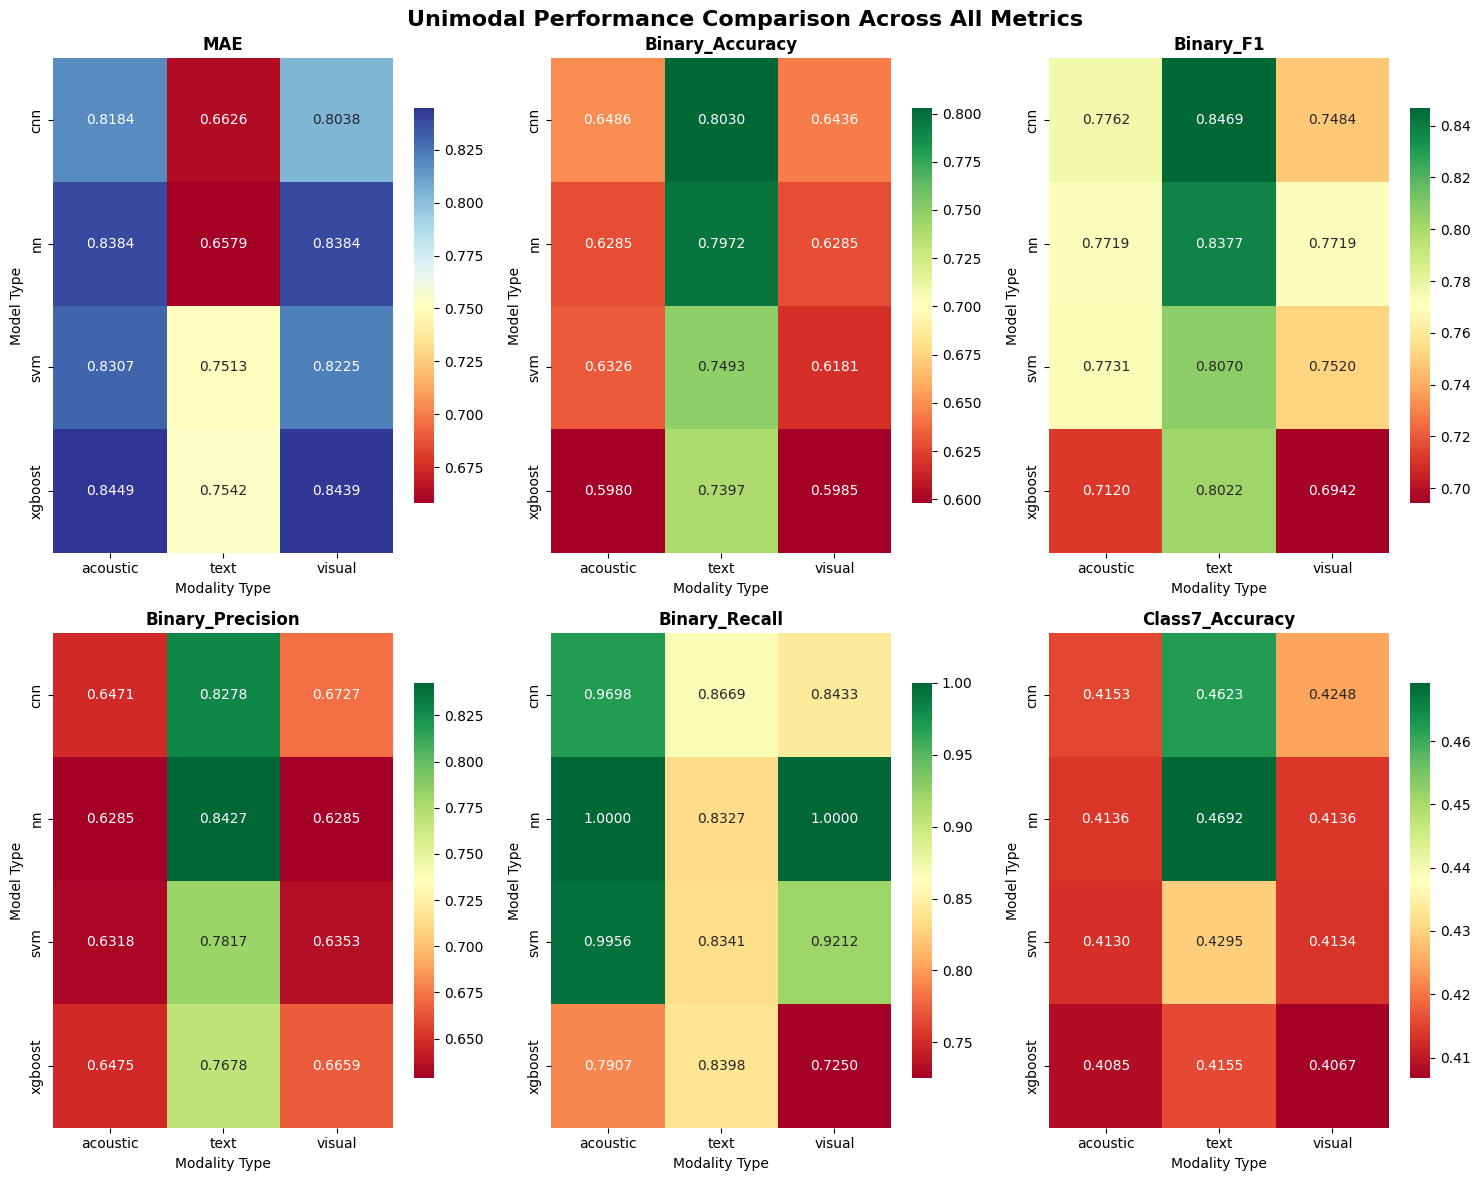

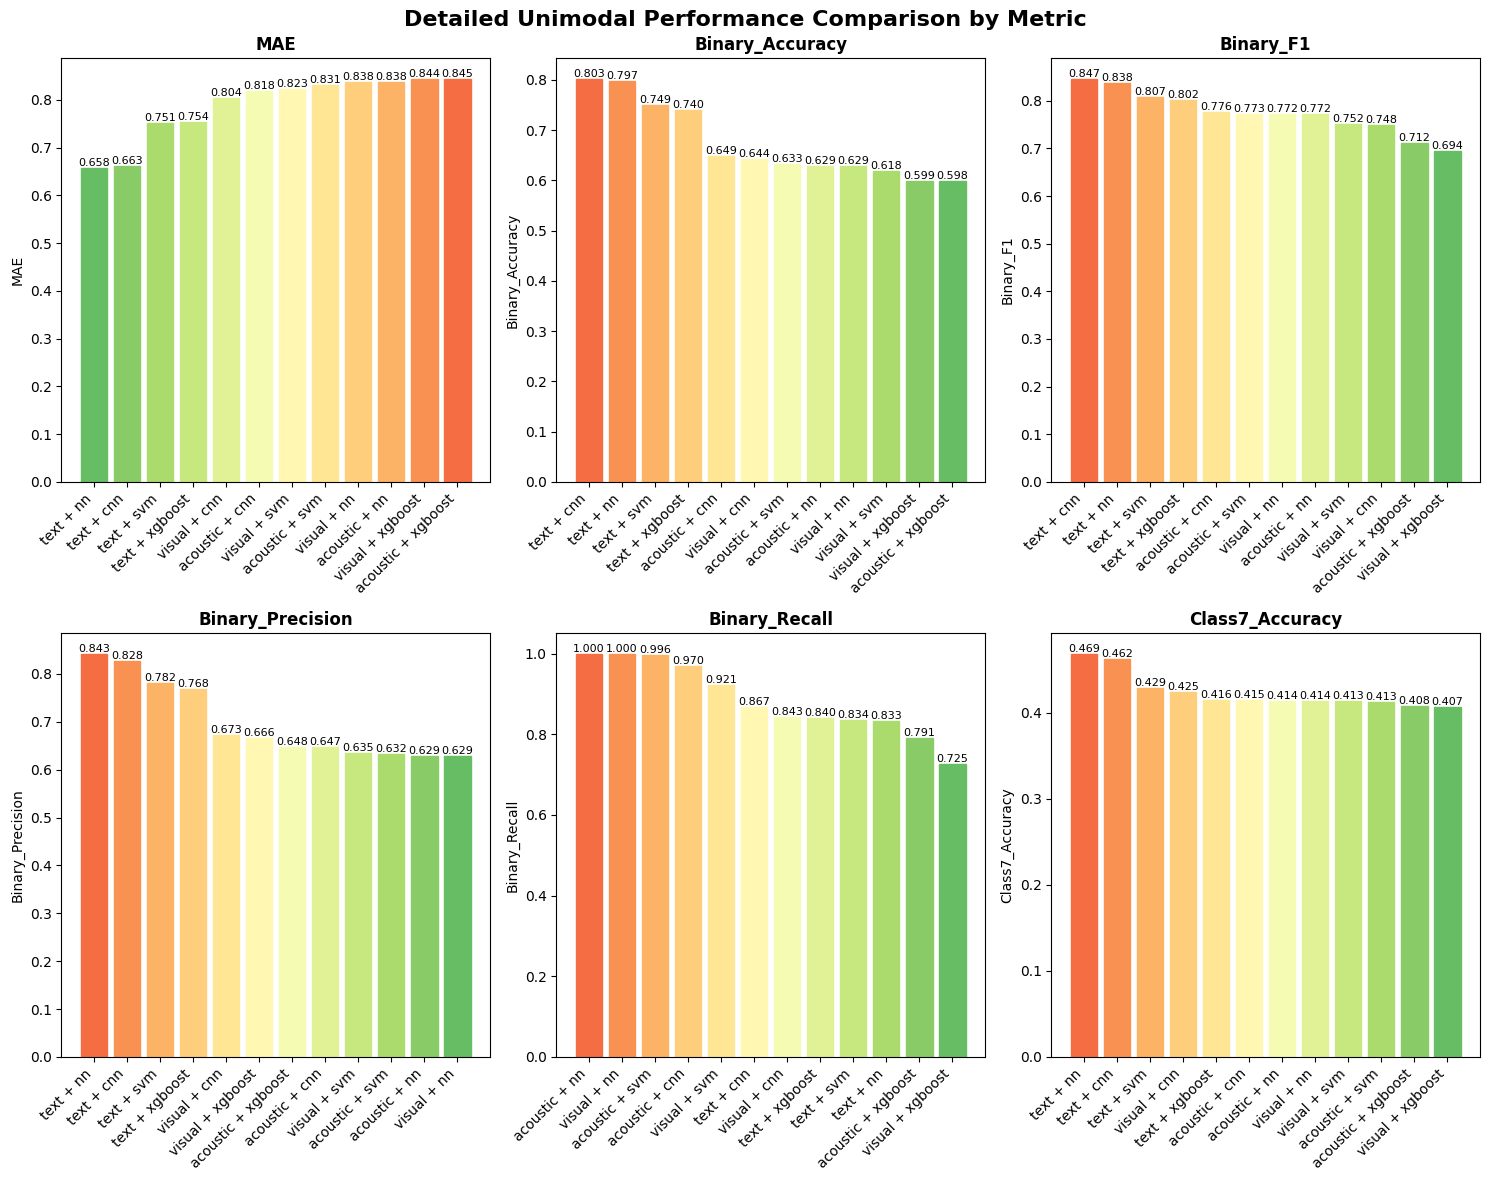

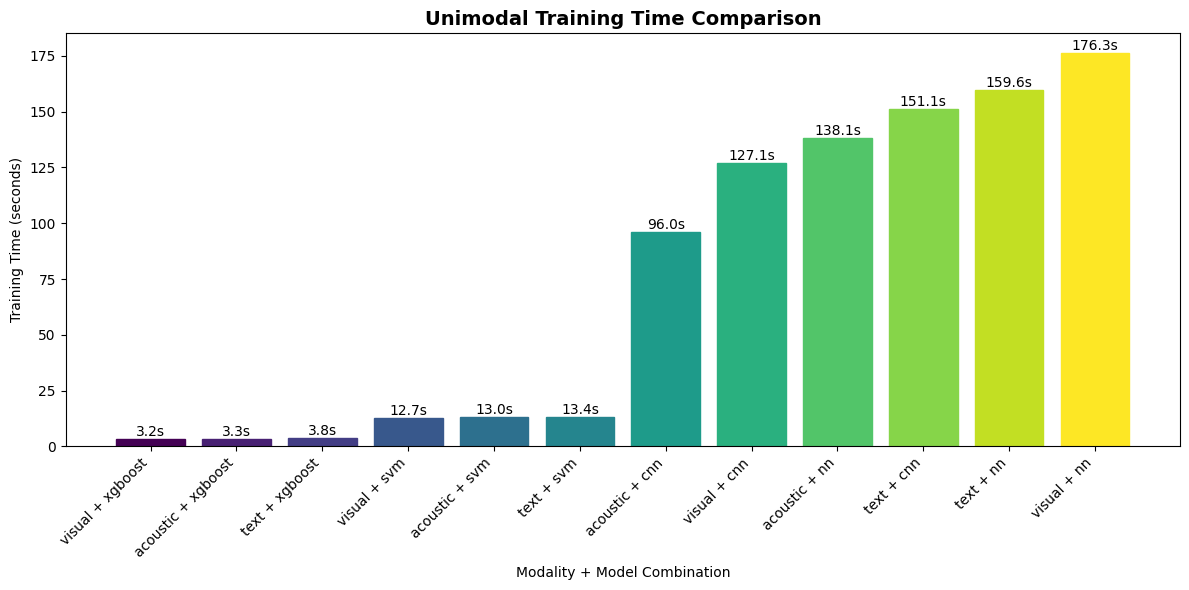


SUMMARY STATISTICS

Best Performance by Metric:
MAE: text + nn (0.6579)
Binary_Accuracy: text + cnn (0.8030)
Binary_F1: text + cnn (0.8469)
Binary_Precision: text + nn (0.8427)
Binary_Recall: acoustic + nn (1.0000)
Class7_Accuracy: text + nn (0.4692)

Overall Ranking (weighted by multiple metrics):

Top 5 Unimodal Combinations:
1. text + cnn (Score: 0.926)
2. text + nn (Score: 0.922)
3. text + svm (Score: 0.593)
4. text + xgboost (Score: 0.546)
5. acoustic + cnn (Score: 0.311)

All results saved to 'unimodal_comparison_results.csv'
Visualization files created:
- unimodal_performance_heatmaps.png
- unimodal_performance_bars.png
- unimodal_training_time_comparison.png

Unimodal evaluation complete!

💾 SAVING COMPREHENSIVE RESULTS TO CSV FILES...
✓ unimodal_comparison_results.csv - Main results


In [37]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 12)

# 1. Heatmap of all metrics
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Unimodal Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'Binary_Accuracy', 'Binary_F1', 'Binary_Precision', 'Binary_Recall', 'Class7_Accuracy']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create pivot table for heatmap
    pivot_data = results_df.pivot(index='Model_Type', columns='Modality_Type', values=metric)
    
    # For MAE, lower is better, so use reverse colormap
    cmap = 'RdYlBu' if metric == 'MAE' else 'RdYlGn'
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap=cmap, ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_xlabel('Modality Type')
    ax.set_ylabel('Model Type')

plt.tight_layout()
plt.savefig('unimodal_performance_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Bar plots for each metric
fig, axes = plt.subplots(2, 3, figsize=fig_size)
fig.suptitle('Detailed Unimodal Performance Comparison by Metric', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    # Create combination labels
    results_df['Combination'] = results_df['Modality_Type'] + ' + ' + results_df['Model_Type']
    
    # Sort by performance (ascending for MAE, descending for others)
    sorted_df = results_df.sort_values(metric, ascending=(metric == 'MAE'))
    
    bars = ax.bar(range(len(sorted_df)), sorted_df[metric])
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(sorted_df)))
    ax.set_xticklabels(sorted_df['Combination'], rotation=45, ha='right')
    
    # Color bars based on performance
    if metric == 'MAE':
        # For MAE, lower is better - color from green (best) to red (worst)
        colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(bars)))
    else:
        # For other metrics, higher is better - color from red (worst) to green (best)
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(bars)))
    
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('unimodal_performance_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Training time comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
results_df['Combination'] = results_df['Modality_Type'] + ' + ' + results_df['Model_Type']
sorted_time_df = results_df.sort_values('Training_Time')

bars = ax.bar(range(len(sorted_time_df)), sorted_time_df['Training_Time'])
ax.set_title('Unimodal Training Time Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Training Time (seconds)')
ax.set_xlabel('Modality + Model Combination')
ax.set_xticks(range(len(sorted_time_df)))
ax.set_xticklabels(sorted_time_df['Combination'], rotation=45, ha='right')

# Color bars based on training time
colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('unimodal_training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Summary statistics table
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Best performance for each metric
print("\nBest Performance by Metric:")
for metric in metrics_to_plot:
    if metric == 'MAE':
        best_idx = results_df[metric].idxmin()
        print(f"{metric}: {results_df.loc[best_idx, 'Modality_Type']} + {results_df.loc[best_idx, 'Model_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")
    else:
        best_idx = results_df[metric].idxmax()
        print(f"{metric}: {results_df.loc[best_idx, 'Modality_Type']} + {results_df.loc[best_idx, 'Model_Type']} "
              f"({results_df.loc[best_idx, metric]:.4f})")

# Overall ranking (you can customize the weighting)
print("\nOverall Ranking (weighted by multiple metrics):")
# Normalize metrics (0-1 scale) and compute weighted score
normalized_df = results_df.copy()
for metric in metrics_to_plot:
    if metric == 'MAE':
        # For MAE, lower is better, so invert
        normalized_df[f'{metric}_norm'] = 1 - (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())
    else:
        # For others, higher is better
        normalized_df[f'{metric}_norm'] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

# Compute weighted score (you can adjust weights)
weights = {'MAE': 0.3, 'Binary_Accuracy': 0.2, 'Binary_F1': 0.2, 'Binary_Precision': 0.1, 'Binary_Recall': 0.1, 'Class7_Accuracy': 0.1}
normalized_df['Overall_Score'] = sum(normalized_df[f'{metric}_norm'] * weights[metric] for metric in weights.keys())

# Sort by overall score
ranked_df = normalized_df.sort_values('Overall_Score', ascending=False)
print("\nTop 5 Unimodal Combinations:")
for i in range(min(5, len(ranked_df))):
    row = ranked_df.iloc[i]
    print(f"{i+1}. {row['Modality_Type']} + {row['Model_Type']} (Score: {row['Overall_Score']:.3f})")

print(f"\nAll results saved to 'unimodal_comparison_results.csv'")
print("Visualization files created:")
print("- unimodal_performance_heatmaps.png")
print("- unimodal_performance_bars.png") 
print("- unimodal_training_time_comparison.png")
print("\nUnimodal evaluation complete!")

# ==========================================================================================
# SAVE COMPREHENSIVE RESULTS TO CSV FILES
# ==========================================================================================

print(f"\n💾 SAVING COMPREHENSIVE RESULTS TO CSV FILES...")

# 1. Main results (already saved above)
print("✓ unimodal_comparison_results.csv - Main results")

In [38]:
results_df


,Modality_Type,Model_Type,MAE,Binary_Accuracy,Binary_F1,Binary_Precision,Binary_Recall,Class7_Accuracy,Training_Time,Combination
0,acoustic,nn,0.838414,0.628509,0.771882,0.628509,1.000000,0.413608,138.123683,acoustic + nn
1,acoustic,cnn,0.818412,0.648597,0.776240,0.647093,0.969790,0.415325,96.021747,acoustic + cnn
2,acoustic,svm,0.830732,0.632636,0.773075,0.631842,0.995622,0.412964,12.985575,acoustic + svm
3,acoustic,xgboost,0.844872,0.597964,0.712005,0.647544,0.790718,0.408457,3.309297,acoustic + xgboost
4,visual,nn,0.838413,0.628509,0.771882,0.628509,1.000000,0.413608,176.315973,visual + nn
5,visual,cnn,0.803771,0.643643,0.748397,0.672721,0.843257,0.424769,127.058269,visual + cnn
6,visual,svm,0.822533,0.618052,0.751966,0.635266,0.921191,0.413393,12.655938,visual + svm
7,visual,xgboost,0.843870,0.598514,0.694194,0.665862,0.725044,0.406740,3.248247,visual + xgboost
8,text,nn,0.657926,0.797193,0.837701,0.842712,0.832750,0.469199,159.577783,text + nn
9,text,cnn,0.662598,0.802972,0.846878,0.827759,0.866900,0.462331,151.097275,text + cnn
